In [21]:
import pickle
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils import *

### read in climatological jet lat, sam index in models calculated in calculate_SAM_inices.ipynb and jet_ACRE_index_interpolated calculated in plot_figure1&4.ipynb

In [22]:
save_directory = '../data'
with open(os.path.join(save_directory, 'sam_models_monthly_2000_2014.pkl'), 'rb') as f:
    sam_models_monthly = pickle.load(f)

with open(os.path.join(save_directory, 'sam_models_daily.pkl'), 'rb') as f:
    sam_models_daily = pickle.load(f)

In [23]:
save_directory = '../data'
# To load the dictionaries later
with open(os.path.join(save_directory, 'climatological_jet_lat_models_monthly_2000_2014.pkl'), 'rb') as f:
    climatological_jet_lat_models = pickle.load(f)

with open(os.path.join(save_directory, 'SAM_ACRE_index_models_with_obs.pkl'), 'rb') as f:
    jet_ACRE_index_interpolated = pickle.load(f)

### plot the jet-ACRE index (model-mean and observed as thick lines and individual model as thin lines)

In [24]:
# this is the newest one in paper
type2_models = ['NorCPM1',
'BCC-ESM1',
'ACCESS-ESM1-5',
'MRI-ESM2-0',
'BCC-CSM2-MR',
'CMCC-CM2-HR4',
'SAM0-UNICON',
'EC-Earth3-CC',]

type1_models = ['CIESM',
'HadGEM3-GC31-LL',
'INM-CM5-0',
'MIROC6',
'CNRM-CM6-1-HR',
'NESM3',
'INM-CM4-8',
'MIROC-ES2L']

In [25]:
jet_ACRE_index_type1 = []
jet_ACRE_index_type2 = []
for models in type1_models+type2_models:
    if models in type1_models:
        jet_ACRE_index_type1.append(jet_ACRE_index_interpolated[models])
    else:
        jet_ACRE_index_type2.append(jet_ACRE_index_interpolated[models])

jet_ACRE_index_type1_mean = np.mean(jet_ACRE_index_type1, axis=0)
jet_ACRE_index_type2_mean = np.mean(jet_ACRE_index_type2, axis=0)

### load regression_cl_sam_models

In [26]:
save_directory = '../data'
with open(os.path.join(save_directory, 'regression_maps_cloud_fraction.pkl'), 'rb') as f:
    regression_maps_models_cl = pickle.load(f)

In [27]:
ds_ceres = xr.open_dataset(f'/bjerknes_raid5/CMIP6_xl7pd/CERES/CERES_EBAF_Ed4.2_Subset_200003-202309.nc')
dataset = ds_ceres.sel(time=slice('2000', '2014'))
latitudes = dataset.variables['lat'][:]

common_latitudes = latitudes.values  

In [28]:
regression_coeffs_list_type2 = []
regression_coeffs_list_type1 = []
for model in regression_maps_models_cl.keys():
    if model in type1_models:
        regression_coeffs_list_type1.append(regression_maps_models_cl[model])
    elif model in type2_models:
        regression_coeffs_list_type2.append(regression_maps_models_cl[model])

regression_coeffs_stack_type1 = np.stack([coeff.values for coeff in regression_coeffs_list_type1])
regression_coeffs_stack_type2 = np.stack([coeff.values for coeff in regression_coeffs_list_type2])
mean_da_type1 = xr.DataArray(np.mean(regression_coeffs_stack_type1, axis=0), dims=regression_coeffs_list_type1[0].dims, coords=regression_coeffs_list_type1[0].coords)
mean_da_type2 = xr.DataArray(np.mean(regression_coeffs_stack_type2, axis=0), dims=regression_coeffs_list_type2[0].dims, coords=regression_coeffs_list_type2[0].coords)

regression_coeffs_stack_type1 = np.stack([coeff.values for coeff in regression_coeffs_list_type1])
num_models = len(regression_coeffs_list_type1)
positive_agreement = (regression_coeffs_stack_type1 > 0)

positive_agreement_sum = np.sum(positive_agreement, axis=0)

agreement_threshold = 0.8 * num_models
agreement_mask = (positive_agreement_sum >= agreement_threshold) | (positive_agreement_sum <= (num_models - agreement_threshold))

nan_mask = ~np.isnan(mean_da_type1.values)  
final_mask_type1 = agreement_mask & nan_mask

regression_coeffs_stack_type2 = np.stack([coeff.values for coeff in regression_coeffs_list_type2])
num_models = len(regression_coeffs_list_type2)
positive_agreement = (regression_coeffs_stack_type2 > 0)

positive_agreement_sum = np.sum(positive_agreement, axis=0)

agreement_threshold = 0.8 * num_models
agreement_mask = (positive_agreement_sum >= agreement_threshold) | (positive_agreement_sum <= (num_models - agreement_threshold))

nan_mask = ~np.isnan(mean_da_type2.values)  
final_mask_type2 = agreement_mask & nan_mask

<>:50: SyntaxWarning: invalid escape sequence '\s'
<>:113: SyntaxWarning: invalid escape sequence '\s'
<>:118: SyntaxWarning: invalid escape sequence '\s'
<>:50: SyntaxWarning: invalid escape sequence '\s'
<>:113: SyntaxWarning: invalid escape sequence '\s'
<>:118: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_23226/2225072669.py:50: SyntaxWarning: invalid escape sequence '\s'
  ax1.set_ylabel('Regression Coefficients (W m$^{-2} \sigma_s^{-1}$)', fontsize=16)
/tmp/ipykernel_23226/2225072669.py:113: SyntaxWarning: invalid escape sequence '\s'
  cbar1.set_label('Regression Coefficient (% $\sigma_s^{-1}$)', fontsize=14)
/tmp/ipykernel_23226/2225072669.py:118: SyntaxWarning: invalid escape sequence '\s'
  cbar2.set_label('Regression Coefficient Diff (% $\sigma_s^{-1}$)', fontsize=14)


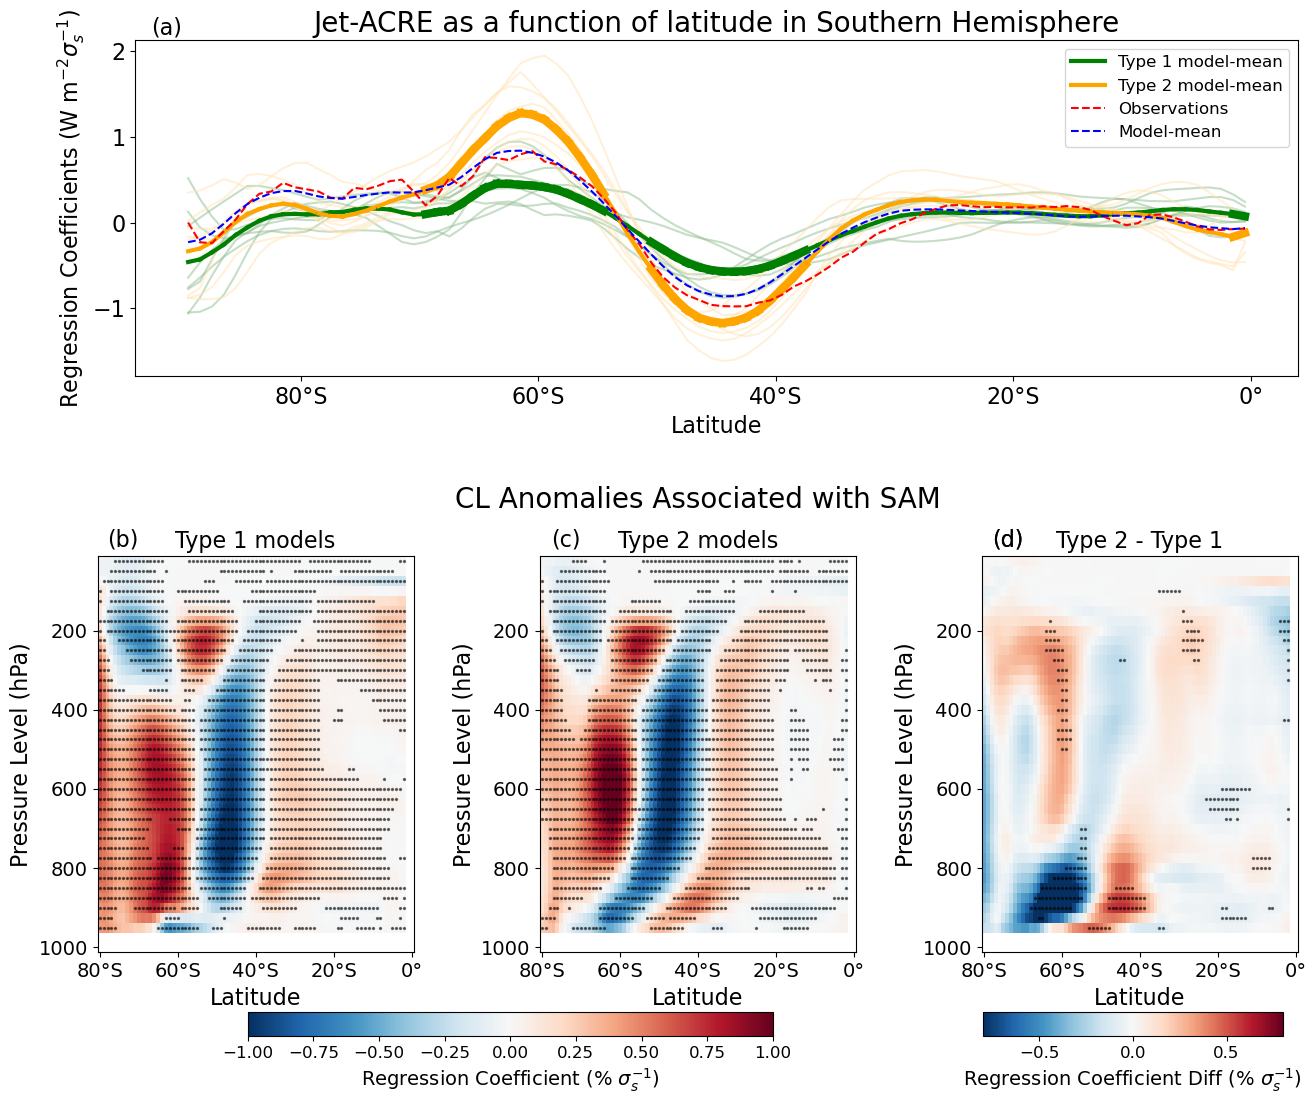

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Create the figure and a GridSpec layout
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(2, 1, height_ratios=[1, 1.5])  # Allocate more space for the bottom row

# Top single-panel plot
p_values = ttest_ind(jet_ACRE_index_type1, jet_ACRE_index_type2, axis=0).pvalue

# Define significance threshold (e.g., 0.05)
significance_threshold = 0.05
significant_regions = p_values < significance_threshold

# Plotting
ax1 = fig.add_subplot(gs[0])

# Plot individual models
for each in jet_ACRE_index_type1:
    ax1.plot(common_latitudes[common_latitudes < 0], each[common_latitudes < 0], color='darkseagreen', alpha=0.5)
for each in jet_ACRE_index_type2:
    ax1.plot(common_latitudes[common_latitudes < 0], each[common_latitudes < 0], color='moccasin', alpha=0.5)

# Plot Type 1 and Type 2 model means with dynamic line thickness
type1_mean = jet_ACRE_index_type1_mean[common_latitudes < 0]
type2_mean = jet_ACRE_index_type2_mean[common_latitudes < 0]
latitudes = common_latitudes[common_latitudes < 0]

# Split into significant and non-significant regions
for i in range(len(latitudes) - 1):
    # Check if the current segment is significant
    if significant_regions[i]:
        linewidth = 6  # Thicker line for significant regions
    else:
        linewidth = 3  # Default line thickness
    
    # Plot each segment separately for Type 1
    ax1.plot(latitudes[i:i+2], type1_mean[i:i+2], color='green', linewidth=linewidth, label=None if i > 0 else 'Type 1 model-mean')
    # Plot each segment separately for Type 2
    ax1.plot(latitudes[i:i+2], type2_mean[i:i+2], color='orange', linewidth=linewidth, label=None if i > 0 else 'Type 2 model-mean')

# Plot observations and model-mean
ax1.plot(latitudes, jet_ACRE_index_interpolated['obs'][common_latitudes < 0], label='Observations', color='red', linewidth=1.5, linestyle='--')
ax1.plot(latitudes, jet_ACRE_index_interpolated['model-mean'][common_latitudes < 0], label='Model-mean', color='blue', linewidth=1.5, linestyle='--')

# Finalize plot
ax1.set_title('Jet-ACRE as a function of latitude in Southern Hemisphere', fontsize=20)
ax1.set_xlabel('Latitude', fontsize=16)
ax1.set_ylabel('Regression Coefficients (W m$^{-2} \sigma_s^{-1}$)', fontsize=16)
ax1.legend(fontsize=12)
latitude_ticks = [-80, -60, -40, -20, 0]
latitude_labels = ['80°S', '60°S', '40°S', '20°S', '0°']
ax1.set_xticks(latitude_ticks)
ax1.set_xticklabels(latitude_labels, fontsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.text(0.04, 1.07, '(a)', transform=ax1.transAxes, fontsize=16, va='top', ha='right')

# Bottom row: 3-panel plot
gs_bottom = GridSpec(1, 3, figure=fig, wspace=0.4, top=0.45, bottom=0.12, left=0.1, right=0.9)  # Adjust spacing for 3 panels

# Panel 1: Type 1 models
ax2 = fig.add_subplot(gs_bottom[0])
mean_da_type1.sel(lat=slice(-80, 0)).plot(ax=ax2, x='lat', y='lev', cmap='RdBu_r', vmin=-1, vmax=1, yincrease=False, add_colorbar=False)
ax2.set_title('Type 1 models', fontsize=16)
ax2.set_xlabel('Latitude', fontsize=16)
ax2.set_ylabel('Pressure Level (hPa)', fontsize=16)
latitude_ticks = [-80, -60, -40, -20, 0]
latitude_labels = ['80°S', '60°S', '40°S', '20°S', '0°']
ax2.set_xticks(latitude_ticks)
ax2.set_xticklabels(latitude_labels)
ax2.tick_params(axis='both', which='major', labelsize=14)
latitudes, levels = np.meshgrid(mean_da_type1['lat'].values, mean_da_type1['lev'].values)
ax2.scatter(latitudes[final_mask_type1], levels[final_mask_type1], color='black', s=2, alpha=0.5)
ax2.text(0.13, 1.07, '(b)', transform=ax2.transAxes, fontsize=16, va='top', ha='right')

# Panel 2: Type 2 models
ax3 = fig.add_subplot(gs_bottom[1])
mean_da_type2.sel(lat=slice(-80, 0)).plot(ax=ax3, x='lat', y='lev', cmap='RdBu_r', vmin=-1, vmax=1, yincrease=False, add_colorbar=False)
ax3.set_title('Type 2 models', fontsize=16)
ax3.set_xlabel('Latitude', fontsize=16)
ax3.set_ylabel('Pressure Level (hPa)', fontsize=16)
latitude_ticks = [-80, -60, -40, -20, 0]
latitude_labels = ['80°S', '60°S', '40°S', '20°S', '0°']
ax3.set_xticks(latitude_ticks)
ax3.set_xticklabels(latitude_labels)
ax3.tick_params(axis='both', which='major', labelsize=14)
latitudes, levels = np.meshgrid(mean_da_type2['lat'].values, mean_da_type2['lev'].values)
ax3.scatter(latitudes[final_mask_type2], levels[final_mask_type2], color='black', s=2, alpha=0.5)
ax3.text(0.13, 1.07, '(c)', transform=ax3.transAxes, fontsize=16, va='top', ha='right')

# Panel 3: Type 2 - Type 1 difference
ax4 = fig.add_subplot(gs_bottom[2])
mean_da_diff = mean_da_type2 - mean_da_type1
mean_da_diff.sel(lat=slice(-80, 0)).plot(ax=ax4, x='lat', y='lev', cmap='RdBu_r', yincrease=False, vmin=-0.8, vmax=0.8, add_colorbar=False)
ax4.set_title('Type 2 - Type 1', fontsize=16)
ax4.set_xlabel('Latitude', fontsize=16)
ax4.set_ylabel('Pressure Level (hPa)', fontsize=16)
latitude_ticks = [-80, -60, -40, -20, 0]
latitude_labels = ['80°S', '60°S', '40°S', '20°S', '0°']
ax4.set_xticks(latitude_ticks)
ax4.set_xticklabels(latitude_labels)
ax4.tick_params(axis='both', which='major', labelsize=14)
ax4.text(0.13, 1.07, '(d)', transform=ax4.transAxes, fontsize=16, va='top', ha='right')

# Add stippling for significant differences between Type 1 and Type 2
ax4.scatter(latitudes[final_mask_diff], levels[final_mask_diff], color='black', s=2, alpha=0.5, label='Significant Difference')
ax4.text(0.13, 1.07, '(d)', transform=ax4.transAxes, fontsize=16, va='top', ha='right')

# Colorbars for the bottom row
cbar_ax1 = fig.add_axes([0.2, 0.05, 0.35, 0.02])  # Adjusted position and size of colorbar for Type 1 and Type 2
cbar1 = plt.colorbar(ax3.collections[0], cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('Regression Coefficient (% $\sigma_s^{-1}$)', fontsize=14)
cbar1.ax.tick_params(labelsize=12)

cbar_ax2 = fig.add_axes([0.69, 0.05, 0.2, 0.02])  # Adjusted position and size of colorbar for Type 2 - Type 1 difference
cbar2 = plt.colorbar(ax4.collections[0], cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('Regression Coefficient Diff (% $\sigma_s^{-1}$)', fontsize=14)
cbar2.ax.tick_params(labelsize=12)

fig.text(0.5, 0.49, 'CL Anomalies Associated with SAM', ha='center', fontsize=20)
#fig.savefig('../figures/fig_3_type1_2.eps', format='eps', dpi=600)
#fig.savefig('../figures/fig_3_type1_2.png', format='png', dpi=600)
plt.show()